In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal as mvn
import os

DATASET_DIR = './datasets'

if not os.path.exists(DATASET_DIR):
    print("Creating a directory for example datasets")
    os.makedirs(DATASET_DIR)
    
mnist = fetch_mldata('MNIST original', data_home=DATASET_DIR)
digit_values = np.unique(mnist.target)

# Naive Bayes Classification

## 1. Top-level

### 1.1 High-level explanation

Naive Bayes is a generative model. That is, instead of finding a decision boundary, it builds up a probability map to predict a classification of input features. 

![](./media/naive_bayes/generative_model.png)

The model's prediction of the probability that the data belongs to a class is given by Bayes' Law:

$$
P(Y|X) = \cfrac{P(Y)P(X|Y)}{P(X)}.
$$

Wherein $P(Y)$ is defined as our **prior** belief of the probability of occurrence of the class $Y$; $P(X|Y)$ is the **likelihood** that features $X$ will occur given that we are looking at class $Y$; and $P(X)$ is the overall probability occurrences of the features. 

This is easier to understand with an example:

Lets consider a Naive Bayes approach to the MNIST dataset. We select an image of a number, 'two', and flatten it to a vector with the intensity values plotted.

![](./media/naive_bayes/two.png)

We can do this for every single 'two', and build up an understanding of the average intensity at each pixel (mean), as well as what pixels see the widest variety of intensities (standard deviation).

![](./media/naive_bayes/all_twos.png)

We make the fundamental assumption now that the occurrence of intensities follows a normal distribution. Doing so, we can generate a probability map based on these two parameters ($\mu$ and $\sigma$).

In [6]:
digit_params = {}
for digit_value in digit_values:
    digits = mnist.data[mnist.target == digit_value]
    digit_params[digit_value] = {
                "mean": digits.mean(axis=0),
                "std": digits.std(axis=0)
    }

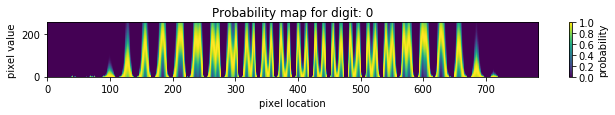

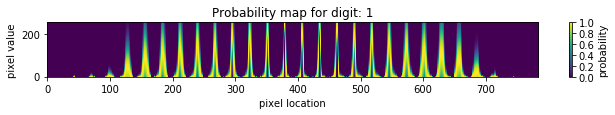

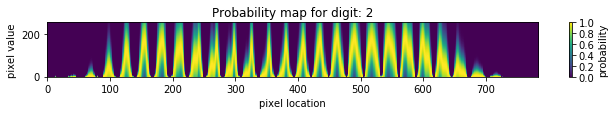

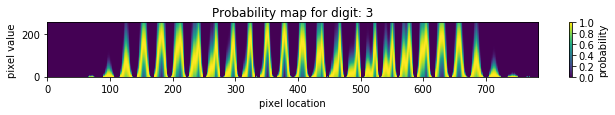

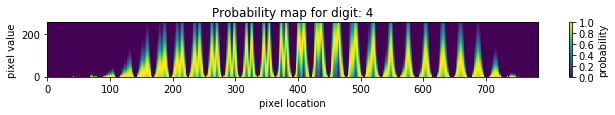

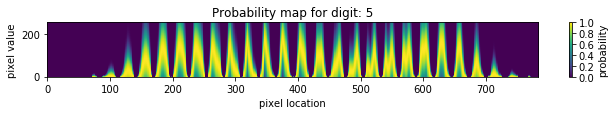

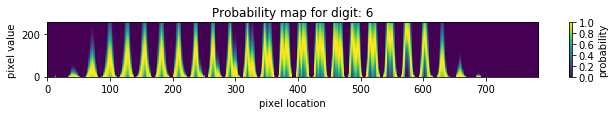

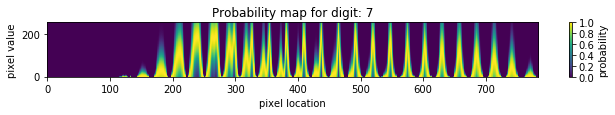

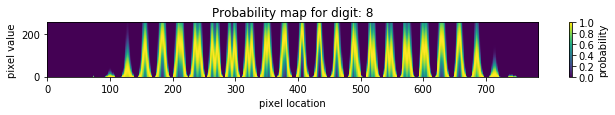

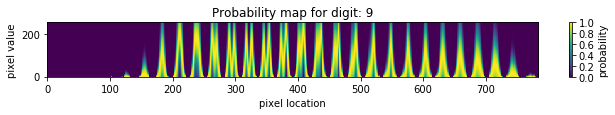

In [11]:
intensities = np.arange(0,255)

for digit_value in digit_values:
    
    prob_map = np.array([ 
        np.exp(-(intensities - mu)**2 / (1e-3 + 2 * (sig)**2))
        for mu, sig in zip(digit_params[digit_value]['mean'], digit_params[digit_value]['std'])
    ])  
    
    fig = plt.figure(figsize=(11,1))
    plt.title("Probability map for digit: {:.0f}".format(digit_value))
    im = plt.imshow(prob_map.T, origin='lower')
    cbar = fig.colorbar(im)
    plt.gca().set_aspect('auto')
    plt.xlabel("pixel location")
    plt.ylabel("pixel value")
    cbar.set_label("probability")
    plt.show()

Each one of these probability maps acts as a thumb-print to describe a class, in this case the class is the digit. Mathematically, we've built up the probability of occurrences of features given a class,

$$
P(X|Y),
$$ 

this is defined as the likelihood.

### 1.2 What scenario should you use it in (classification vs regression, noisy data vs clean data)?

#### 1.2.1 Classification vs Regression

NB is a generative model for classification

#### 1.2.2 Noisy data

NB is insensitive to small changes in data. 
Noisy data will hurt the models performance; however, NB handles the input noise better than any other available models. 

Consider two cases of noise: **background** and **incorrect classification**.

An example of **background** noise might be stop words, like "the", "is", "and", "at", or "which". If you were building a spam/not-spam classifier for emails. Then these words would show up with the same regularity in each classification model, that is, the *likelihood* of seeing "the" is the same for an email that is spam and one that is not spam:

$$
P( X{=}\text{"the"} \,|\, \text{spam} ) = P( X{=}\text{"the"} | \neg \text{spam} ).
$$

In this case, the  prediction for spam/not-spam would both increase by the same constant, making this feature irrelevant for the classification decision.

In summary, NB is very good at handling noisy background data.

In the case of noise introduced by **incorrect classifications**. NB is the best model to use [[2]](#ref) .


#### 1.2.3 Missing values

Naive Bayes is very capable of handling missing values. In this case, only the likelihoods based on the observed values are calculated. 

$$
P(x_1 + \cdots + x_j + \cdots + x_d | y) = \prod^d_{i \neq j} P(x_i | y)
$$

Wherein $x_j$ is a value missing during inference.

#### 1.2.4 Outliers

Outliers will not skew the learning model, because of the assumption of the data distribution. In the below example, the outlier does not significantly skew the PDF because its location can be described by $P(x)$ **[check this reasoning]**

![](./media/naive_bayes/gauss.png)


For the same reason, Naive Bayes is not used for outliers detection.

#### 1.2.5 Minority Class

As long as you can build a descriptive distribution for the likelihood, it is appropriate model to use.


### 1.3 What assumptions does the model make about the data? (Linear, etc)?

This model makes the fundamental assumptions that the data points are distributed by the probability function you select as a the likelihood. In the example about NB will classify the data as described by a Normal distribution. It will make this assumption even if the sample histogram does not immediately mimic the assume PDF, as below.

![](./media/naive_bayes/pdf.png)


### 1.4 When does the model break / fail (adv & dis-advantages)?

Naive Bayes fails when independence is not true between the input features. For example: consider classifying the phrase: "Chicago Bulls". Naive Bayes will classify this as a 'location' and an 'animal'. However, we know from context that this is neither of these things, and the input should instead be classified as 'basketball team'.

Another failure point with Naive Bayes is it's inability to separate classes when the only thing distinguishing them is their correlation. Because it is inherently taking a naive approach, it cannot distinguish between the two examples in the below image, as the probability distribution functions are completely overlapped. 

![](./media/naive_bayes/correlation.png)

 > In simple terms, a naive Bayes classifier assumes that the presence (or absence) of a particular feature of a class is unrelated to the presence (or absence) of any other feature, given the class variable. For example, a fruit may be considered to be an apple if it is red, round, and about 4" in diameter. Even if these features depend on each other or upon the existence of the other features, a naive Bayes classifier considers all of these properties to independently contribute to the probability that this fruit is an apple.

**Zero-frequency occurrence**

Because the finally probability is a function of the products of the likelihood, if an occurrence has never been seen before, the predicted probability will be 0.

$$
P(x_1 + \cdots + x_j + \cdots + x_d | y) = P(x_1|y) \times \cdots \times \underbrace{P(x_j|y)}_0 \times \cdots \times P(x_d|y)
$$

To account for this, a distribution must be assumed. This allows occurrence to be interpolated. 

### 1.5 Use cases / alternatives when it breaks

NB is explainable, just ask Chao

[Typical replacements](https://blogs.sas.com/content/subconsciousmusings/files/2017/04/machine-learning-cheet-sheet.png)

http://peekaboo-vision.blogspot.de/2013/01/machine-learning-cheat-sheet-for-scikit.html

## 2. A bit more detail

### 2.1 How do you normalize the data for the model, if you need to?

Although it is not theoretically necessary to normalize the data going into a NB classifier, not doing so can add unnecessary complexity: 

During training of the model, a smoothing parameter is added to the standard deviation to avoid division by zero. i.e. $\exp\left \{ (\mu-x)^2 / 2\sigma^2 \right \}$

If the features varied in range, then the smoothing parameter would have to change to reflect this. This value can have a significant effect on the accuracy of the model. To convince yourself of this, try changing $\epsilon$ in the code below. Typically a min-max normalization is used [[citation needed]](#ref).
 
### 2.2  What's the complexity — runtime, parameters?

NB is one of the fastest learning methods. 

For number of classes $c$, number of instances $n$, number of dimensions $d$; the time complexity at training will be of order

$$
\mathcal{O}(nd+cd) \approx \mathcal{O}(nd)
$$

For a single input at inference, the complexity is

$$
\mathcal{O}(dc)
$$

Of the ML models is is the second most compact w.r.t. space complexity, of order

$$
\mathcal{O}(dc)
$$

Only decision trees are more compact. [[1]](#refs)

## 3. In-depth

### 3.1 Probabilistic Interpretation

The model assumes that the features, $X$, are *conditionally* independent from one another. For example, in a data set it might appear that there is a correlation between the occurrences of $B$ and $C$. However, if it can be assumed that $B$ and $C$ are actually *mutually* independent then the correlation can be described by the existence of an external factor, $A$.

![](./media/naive_bayes/cond_indp.png)

As an example: if one were to look at the rate of heat stroke and the action of going to the beach, there might be a correlation. However, there is nothing intrinsic about going to the beach, that causes heat stroke. So if we consider an external factor, the temperature, we can model these features as mutually independent. Such that you're more likely to go to the beach when its hot, and your more likely to get heatstroke when its hot. In a NB classifier, the predicted class is this hidden dependence. Such that:

$$
P(Y{=}A | x_1{=}B, x_2{=}C)
$$

### 3.2 Derivation

The probability of a event $A$ and $B$ occurring, with the assumption of conditional independence is 

$$
P(A \cap B) = P(A|B)P(A).
$$

Likewise, the probability of a event $B$ and $A$ occurring is 

$$
P(B \cap A) = P(B|A)P(B).
$$

Because $P(A \cap B) = P(B \cap A)$ we can set the two equations equal to each other and find a description for the probability of $A$ occurring, given $B$ occurring:

$$
P(A|B) = \cfrac{P(B|A)P(B)}{P(A)}.
$$

I don't find the terms $A$ and $B$ particularly illuminating, so we can rewrite this in the Diachronic form: describing the probability of a hypothesis, $H$, being true, given some evidence, $E$, existing. 

$$
P(H|E) = \cfrac{P(E|H)P(H)}{P(E)}.
$$

Furthermore, the probability of an event, $P(E)$, is not always clear. I believe is it more obvious to write this in terms of $P(E)$ as a normalization constant:

$$
P(H|E) = \cfrac{P(E|H)P(H)}{\sum_{H'} P(E|H')P(H')}.
$$

If we are only concerned with "What is the most probably hypothesis that describes evidence $E$". We can drop the normalization, because it is constant across all predictions, and just take the hypothesis with the maximum value. Additionally, we take the log of the probabilities, to reduce the complexity of calculating the exponent in the Gaussian PDF.  

$$
\hat{y} = \arg \max_i \left \{ \log P(y_i | X)  \right \}
$$

such that

$$
\log P(y_i | X) \propto \log P(X|y_i) + \log P(y_i)
$$

and $\hat{y}$ is equal to the most likely hypothesis for multiple evidence, $X$.

### 3.3 Simple Implementation

In [23]:
class NaiveBayes:
    
    def train(self, X, Y, epsilon=1e-2):
        self.params = {}
        
        for c in np.unique(Y):
            current_x = X[Y==c]
            
            self.params[int(c)] = {
                'means':current_x.mean(axis=0),
                'vars':current_x.var(axis=0) + epsilon,
                'prior':len(Y[Y==c])/len(Y)
            }
                
    
    def predict(self, X):
        N, D = X.shape
        K = len(self.params)
        P = np.zeros((N,K))
        
        for c, p in self.params.items():
            P[:,c] = mvn.logpdf(X, mean=p['means'], cov=p['vars']) + np.log(p['prior'])

        return np.argmax(P, axis=1)
    
            
    def evaluate(self, X, Y):
        P = self.predict(X)
        return np.mean(Y == P)

In [24]:
# Normalize with min-max scaling. The data doesn not need to be normalized; however, the smoothing parameter 
# in training will have to change to compinsate for this. If not normalizing, try epsilon = 255
data =  mnist.data
data = data - data.min()
data = data / data.max()

xtrain, xtest, ytrain, ytest = train_test_split(data, mnist.target)

nb = NaiveBayes()
nb.train(xtrain, ytrain)
print("Accuracy on MNIST classification: {:.2f}%".format(100*nb.evaluate(xtest, ytest)))

Accuracy on MNIST classification: 80.66%


## 4. More on training the model

### 4.1  How to deal with imbalanced data?

As long as you can build a discriptive distribution for the liklihood, it is appropriate model to use.

### 4.2 How to stop the model from over/under fitting?

NB will not over-fit, high bias model, ask Andy.



### 4.3 What if you have MANY more features than sample points? Vice versa? (A variation of the above over/under fitting)

One of the (relative) best classifiers for features >> data. Naive assumptions leads to high bias, so no worries of overfitting with lots of features. Not much literature on the inverse.

### 4.4 How do you regularize the model? Tradeoffs?

You wouldn't, it wont over-fit.

### 4.5 How can you validate the model?

Accuracy, F1, percision, recall, some other stuff. 

Must be evaluated against the base preformance, i.e. the prior.  

### 4.6 Does the model emphasize Type 1 or Type 2 errors?

Not much literature on it. But intuitively, you should be able to tune your priors to adjust FPR/FNR. or adjust threshold, Data-dependent.

## 5. Remaining Questions

Top-level
 - ~~What is the high-level version, explain in layman's terms~~
 - ~~What scenario should you use it in (classification vs regression, noisy data vs clean data)?~~
 - ~~How does this deal with outliers? Skewed data?~~
 - ~~What assumptions does the model make about the data? (Linear, etc)?~~
 - ~~What types of features does the model use (continuous vs categorical)?~~
 - ~~When does the model break/fail (adv & dis-advantages)?~~
 - ~~use cases/alternatives when it breaks~~

A bit more detail:
 - ~~How do you normalize the data for the model, if you need to?~~
 - ~~How to initialize parameters at beginning (e.g. where to put centroid in KMeans)~~
 - ~~What's the loss function used (if many, what are tradeoffs of each)?~~
 - ~~What optimizers can you use here?~~
 - ~~What's the complexity — runtime, parameters?~~
 - ~~How does it scale with # of features or input data?~~
 
In-depth
 - ~~probabilistic interpretation~~
 - ~~Derive the math (only for a couple models)~~
 - ~~Code up implementation (only for a couple models)~~

More on training the model (not model-specific, this should be common for most of the models):
 - ~~How to deal with imbalanced data?~~
 - ~~How well does it generalize to unseen data (over-fitting vs under-fitting)?~~
 - ~~What if you have MANY more features than sample points? Vice versa? (A variation of the above over/under fitting)~~
 - ~~How do you regularize the model? Tradeoffs?~~
 - ~~How can you validate the model?~~
 - ~~Does the model emphasize Type 1 or Type 2 errors?~~
 
 
 <div id='ref'></div>
 ## 6. References
 
  1. http://www.inf.ed.ac.uk/teaching/courses/iaml/slides/naive-2x2.pdf
  2. https://www.quora.com/Which-is-more-robust-to-noisy-data-a-Decision-Tree-or-Naive-Bayes